In [5]:
# import necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

In [6]:
# read the dataset
df=pd.read_table('daily_sales-2.txt', sep=',')
df.head(10)

,shelf_id,date,product_id,quantity,sale_price,inventory,weekend,weeknum,past_average,past_max,...,second_type_id_dummy_ 9,second_type_id_dummy_10,qu_dummy_1,qu_dummy_2,qu_dummy_3,qu_dummy_4,qu_dummy_5,qu_dummy_6,qu_dummy_7,qu_dummy_8
0,1,1,3,1,5.99,7,0,1,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,3,0,5.99,6,1,1,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,3,0,5.99,6,1,1,0.500000,1,...,0,0,0,0,0,0,0,0,0,0
3,1,4,3,2,5.99,6,0,2,0.333333,1,...,0,0,0,0,0,0,0,0,0,0
4,1,5,3,1,5.99,4,0,2,0.750000,2,...,0,0,0,0,0,0,0,0,0,0
5,1,6,3,1,5.99,3,0,2,0.800000,2,...,0,0,0,0,0,0,0,0,0,0
6,1,7,3,2,5.99,2,0,2,0.833333,2,...,0,0,0,0,0,0,0,0,0,0
7,1,8,3,0,5.99,9,0,2,1.000000,2,...,0,0,0,0,0,0,0,0,0,0
8,1,9,3,0,5.99,9,1,2,0.875000,2,...,0,0,0,0,0,0,0,0,0,0
9,1,10,3,0,5.99,9,1,2,0.777778,2,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# all the features
df.columns

Index(['shelf_id', 'date', 'product_id', 'quantity', 'sale_price', 'inventory',
       'weekend', 'weeknum', 'past_average', 'past_max', 'past_var',
       'last_weekday_sale', 'promotion', 'num_p', 'category_dummy_1',
       'category_dummy_2', 'type_id_dummy_1', 'type_id_dummy_2',
       'type_id_dummy_3', 'type_id_dummy_4', 'second_type_id_dummy_ 1',
       'second_type_id_dummy_ 2', 'second_type_id_dummy_ 3',
       'second_type_id_dummy_ 4', 'second_type_id_dummy_ 5',
       'second_type_id_dummy_ 6', 'second_type_id_dummy_ 7',
       'second_type_id_dummy_ 8', 'second_type_id_dummy_ 9',
       'second_type_id_dummy_10', 'qu_dummy_1', 'qu_dummy_2', 'qu_dummy_3',
       'qu_dummy_4', 'qu_dummy_5', 'qu_dummy_6', 'qu_dummy_7', 'qu_dummy_8'],
      dtype='object')

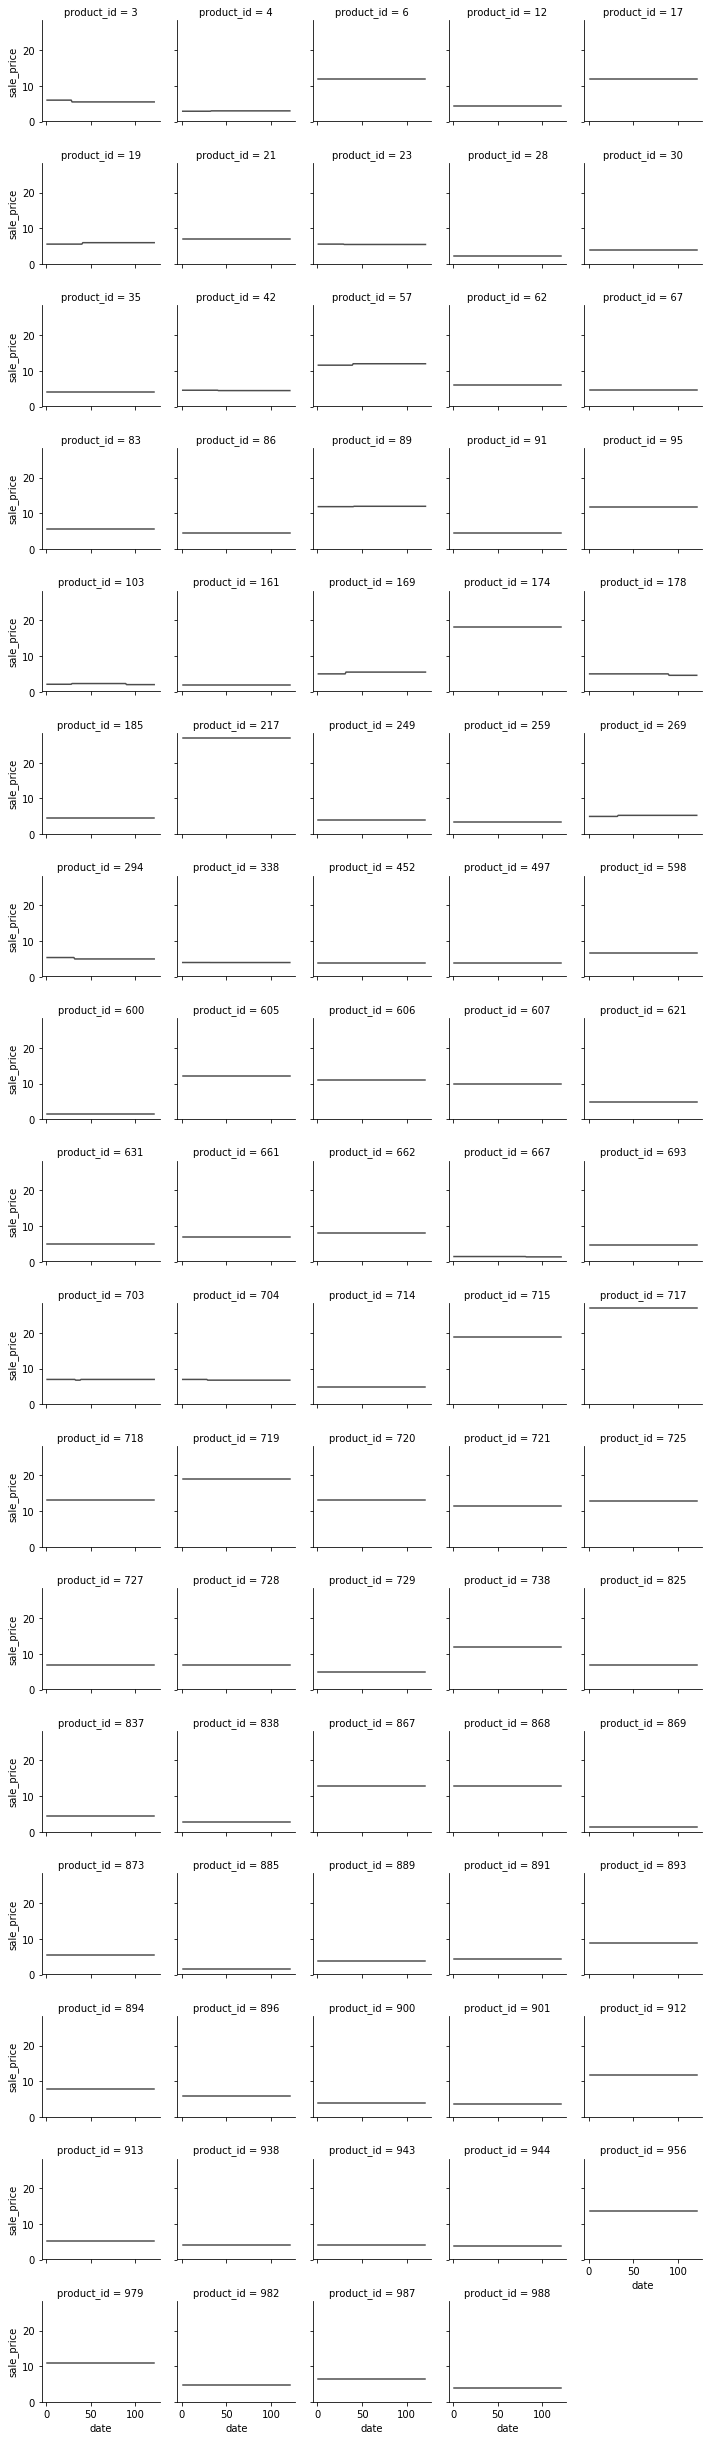

In [8]:
# whether the price change over time,
g = sns.FacetGrid(df[df['shelf_id']==1], col="product_id", col_wrap=5, height=2)
g.map(sns.lineplot, "date", "sale_price", color=".3", ci=None);

In [25]:
df['shelf_id'].value_counts()

9       12221
4       10285
1       10164
36      10164
3       10043
42       9559
638      9559
38       9559
31       9438
27       9438
30       9317
376      9317
525      9317
29       9196
702      9196
24       9075
1436     8954
509      8954
1207     8833
360      8833
614      8712
528      8712
1484     8712
355      8712
34       8712
583      8591
40       8591
8        8470
25       8470
405      8349
        ...  
830      5324
10       5324
1478     5324
435      5324
549      5324
394      5203
371      5082
13       5082
380      5082
543      5082
358      4840
381      4719
382      4719
582      4719
481      4719
429      4719
591      4598
589      4477
733      4356
1686     3509
550      3509
379      3388
770      3388
1739     3388
513      3025
735      2783
736      2299
369      2057
32        484
2         121
Name: shelf_id, Length: 188, dtype: int64

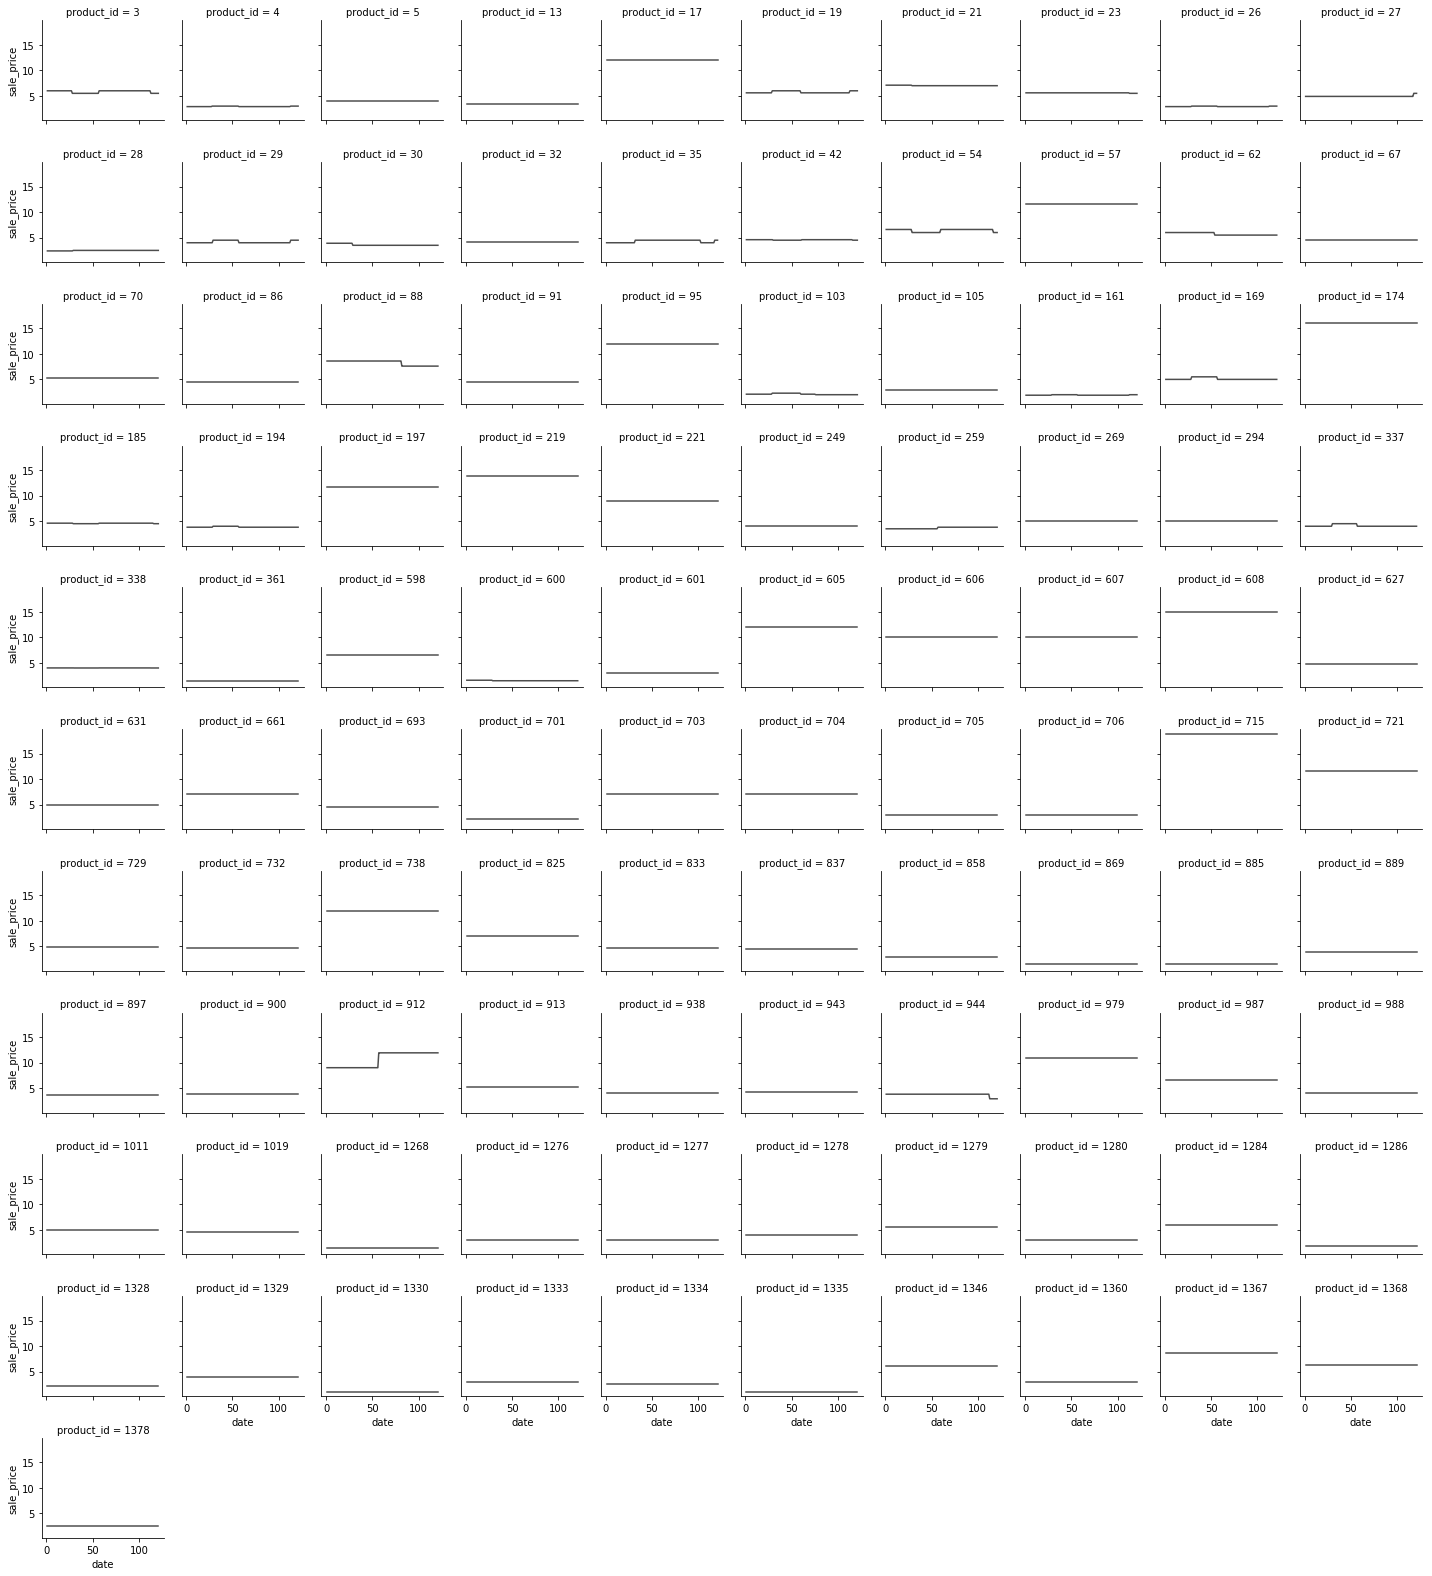

In [9]:
# whether the price change over time,
g = sns.FacetGrid(df[df['shelf_id']==9], col="product_id", col_wrap=10, height=2)
g.map(sns.lineplot, "date", "sale_price", color=".3", ci=None);

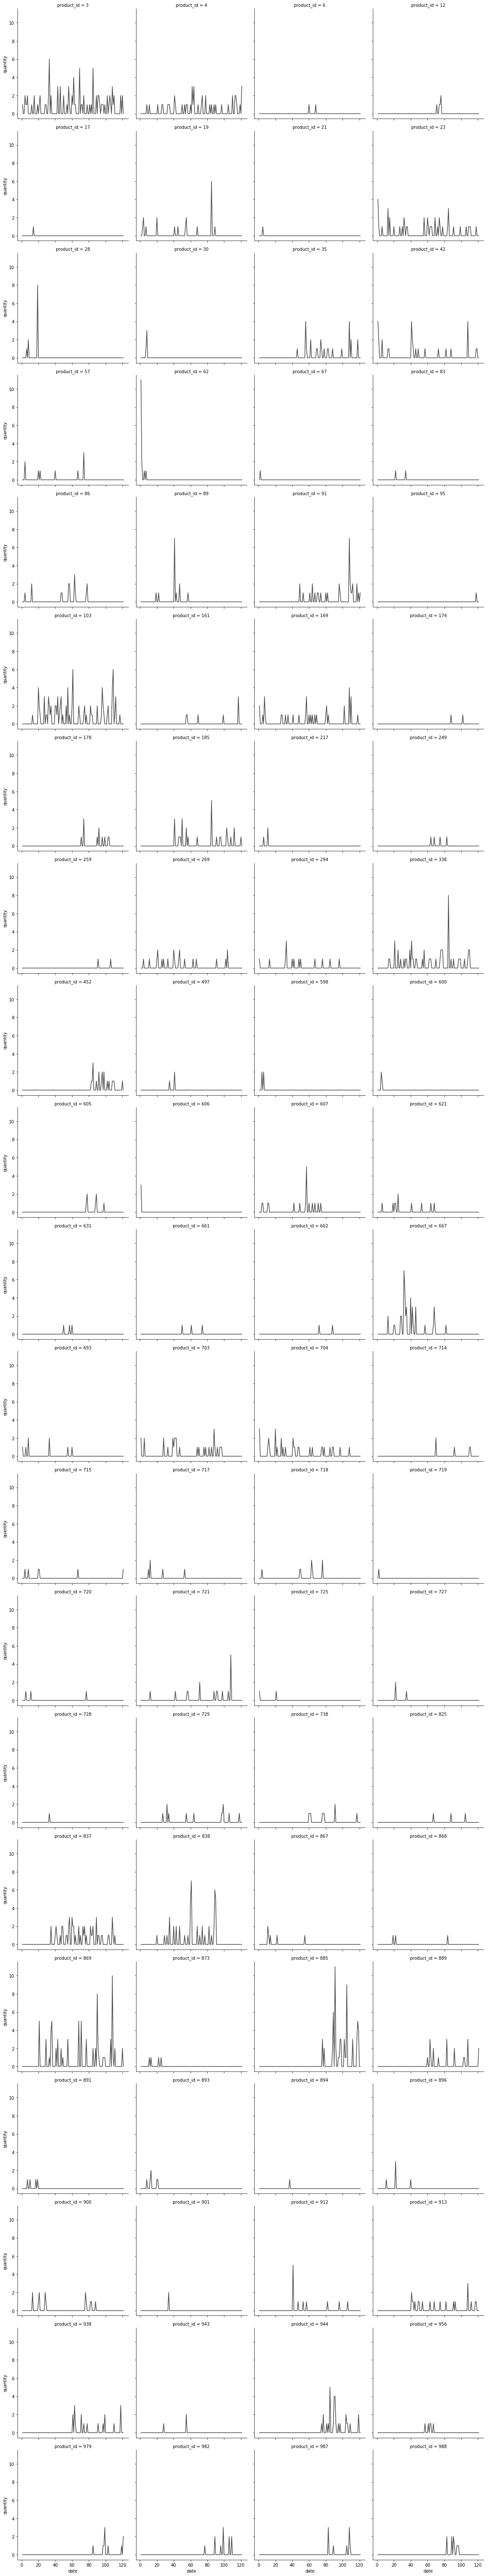

In [15]:
# explore the trend of demand over time
p_demand_trent = sns.FacetGrid(df[df['shelf_id']==1], col="product_id", col_wrap=4, height=4)
p_demand_trent.map(sns.lineplot, "date", "quantity", color=".3", ci=None);

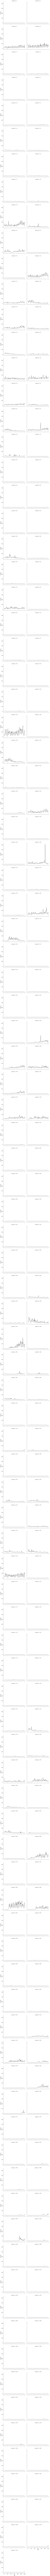

In [18]:
# explore the overall trend of demand over time
df_product=df.groupby(['product_id','date']).quantity.sum()
df_product=df_product.reset_index().copy()
p_all_demand_trend=sns.FacetGrid(df_product, col="product_id", col_wrap=2, height=5)
p_all_demand_trend.map(sns.lineplot, "date", "quantity", color=".3", ci=None);

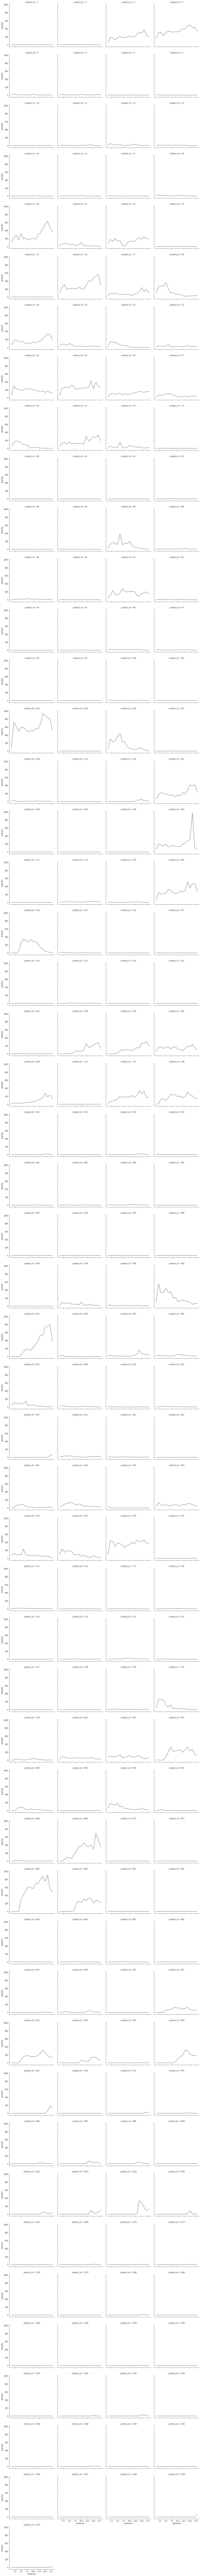

In [10]:
# explore the weekly demand trend
df_weekly=df.groupby(['product_id','weeknum']).quantity.sum()
df_weekly=df_weekly.reset_index().copy()
p_all_demand_trend=sns.FacetGrid(df_weekly, col="product_id", col_wrap=4, height=4)
p_all_demand_trend.map(sns.lineplot, "weeknum", "quantity", color=".3", ci=None);

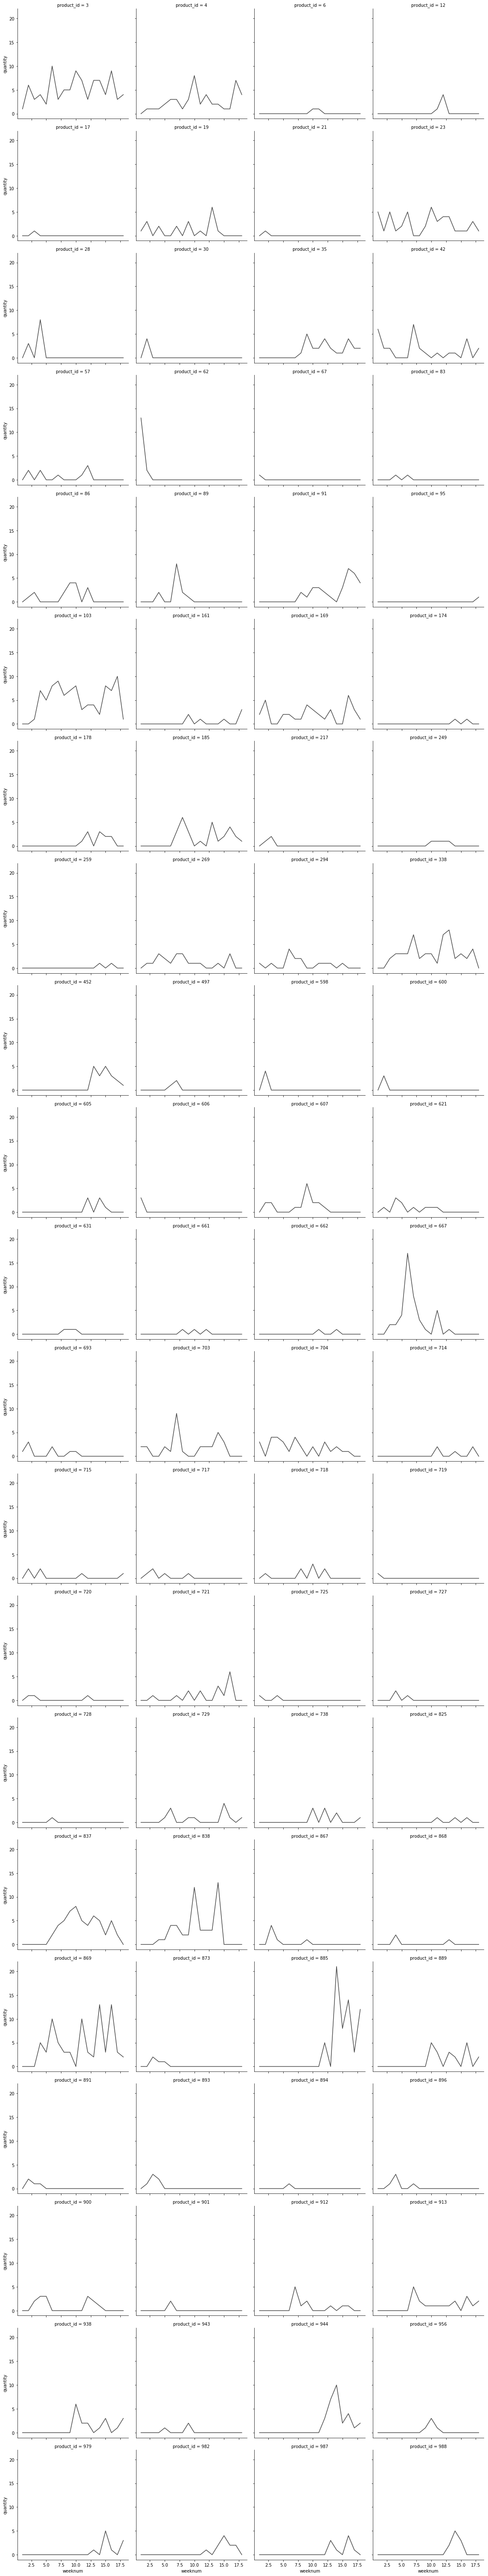

In [26]:
# explore the weekly demand trend for one shelf
df_weekly_shelf=df[df['shelf_id']==1].groupby(['product_id','weeknum']).quantity.sum()
df_weekly_shelf=df_weekly_shelf.reset_index().copy()
p_all_demand_trend=sns.FacetGrid(df_weekly_shelf, col="product_id", col_wrap=4, height=4)
p_all_demand_trend.map(sns.lineplot, "weeknum", "quantity", color=".3", ci=None);

In [ ]:
# compare the demand trend of each weekday
